In [1]:
!pip install biopython
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.distributions import SineBivariateVonMises
from pyro.distributions import Normal
import numpy as np
from Bio import PDB
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# applies a piecewise function to input tensor x
def g(x):
    """
    g(x) =
    - x + 0.5,   if x >= 0
    - sigmoid(x), if x < 0
    Parameters: x: (Tensor) The input tensor.
    """
    assert isinstance(x, torch.Tensor), "Input x must be a torch.Tensor"
    return torch.where(x >= 0, x + 0.5, torch.sigmoid(x))

# computes a logarithmic transformation of x with smooth transitions:
def log_g(x):
    """
    log_g(x) =
    - log(x + 0.5),    if x >= 0
    - -softplus(-x),   if x < 0
    Parameters: x: (Tensor) The input tensor.
    """
    assert isinstance(x, torch.Tensor), "Input x must be a torch.Tensor"
    return torch.where(x >= 0, (x + 0.5).log(), -F.softplus(-x))


class MiniGRU(nn.Module):
    """
    Parameters:
    - input_size: (int) Dimension of input feature vector.
    - hidden_size: (int) Dimension of hidden state.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear_z = nn.Linear(input_size, hidden_size)  # update gate
        self.linear_h = nn.Linear(input_size, hidden_size)  # candidate hidden state

    def forward(self, x_t, h_prev):
        """
        Parameters:
        - x_t: (Tensor) Shape (input_size,), input at time step t.
        - h_prev: (Tensor) Shape (hidden_size,), previous hidden state.
        """
        z = torch.sigmoid(self.linear_z(x_t))  # compute update gate
        h_tilde = g(self.linear_h(x_t))  # compute candidate hidden state
        h_t = (1 - z) * h_prev + z * h_tilde  # compute new hidden state

        assert h_t.shape == h_prev.shape, f"Output h_t shape mismatch: expected {h_prev.shape}, got {h_t.shape}"
        return h_t  # (hidden_size,)

def parallel_scan_log(log_coeffs, log_values):
    """
    Parameters:
    - log_coeffs: (Tensor) Shape (seq_len, hidden_size), log-space coefficients.
    - log_values: (Tensor) Shape (seq_len + 1, hidden_size), log-space values to be accumulated.
    """
    a_star = F.pad(torch.cumsum(log_coeffs, dim=0), (0, 0, 1, 0))  # compute cumulative sum
    log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=0)  # log-space accumulation
    log_h = a_star + log_h0_plus_b_star  # convert back from log-space

    assert log_h.shape == log_values.shape, "Shape mismatch in log-space scan computation"
    return torch.exp(log_h)[1:]  # (seq_len, hidden_size)


class MiniGRU_parallel(nn.Module):
    """
    Parameters:
    - input_size: (int) Dimension of input feature vector.
    - hidden_size: (int) Dimension of hidden state.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear_z = nn.Linear(input_size, hidden_size)  # update gate
        self.linear_h = nn.Linear(input_size, hidden_size)  # candidate hidden state

    def forward_parallel(self, x, h0):
        """
        Parameters:
        - x: (Tensor) Shape (seq_len, input_size), input sequence.
        - h0: (Tensor) Shape (hidden_size,), initial hidden state.
        """
        seq_len, _ = x.shape  # extract sequence length

        k = self.linear_z(x)  # compute update gate pre-activation (seq_len, hidden_size)
        log_z = -F.softplus(-k)  # convert to log-space (seq_len, hidden_size)
        log_coeffs = -F.softplus(k)  # compute log-space coefficients (seq_len, hidden_size)

        log_h0 = log_g(h0)  # convert initial hidden state to log-space (hidden_size,)

        log_tilde_h = log_g(self.linear_h(x))  # compute candidate states in log-space (seq_len, hidden_size)

        sequence = torch.cat([log_h0.unsqueeze(0), log_z + log_tilde_h], dim=0)  # concatenate log-space sequence

        h = parallel_scan_log(log_coeffs, sequence)  # compute hidden states in log-space

        assert h.shape == (seq_len, self.hidden_size), f"Output h shape mismatch: expected {(seq_len, self.hidden_size)}, got {h.shape}"

        return h  # (seq_len, hidden_size)

In [4]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_size, output_size):
        """
        :param z_dim: Latent variable dimension (16)
        :param hidden_size: GRU hidden state dimension (128)
        :param output_size: Output von Mises parameter dimension (5: mus(2), kappas(2), corrs(1))
        """
        super().__init__()
        self.rnn = MiniGRU(z_dim, hidden_size)
        self.fc_embed = nn.Linear(hidden_size, z_dim)
        self.fc = nn.Linear(z_dim, output_size)
        self.h_0 = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, z, seq_len):
        """
        :param z: (z_dim,) Initial latent variable vector
        :param seq_len: Sequence length
        :return: (seq_len, output_size) von Mises parameter for each time step
        """
        # get the current device (CPU/GPU)
        device = z.device
        # Make sure h_0 is on the same device
        h = self.h_0.to(device)
        x_t = z

        # use tensor instead of list
        outputs = torch.zeros(seq_len, 5, device=device)

        for t in range(seq_len):
            # update the hidden state h
            h = self.rnn(x_t, h)
            x_t = self.fc_embed(h)
            out = self.fc(x_t)

            # calculate von Mises paramaters
            mus = torch.pi * torch.tanh(out[0:2])  # mus ∈ [-pi, pi]
            kappas = 10 + 90 * torch.sigmoid(out[2:4])  # kappas ∈ [10, 100]
            corrs = 0.9 * torch.tanh(out[4:5])  # corrs ∈ [-0.9, 0.9]

            outputs[t] = torch.cat([mus, kappas, corrs], dim=0)


        assert outputs.shape == (seq_len, 5), f"Decoder output shape mismatch: {outputs.shape}"
        return outputs

In [5]:
class Encoder(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_size):
        super().__init__()
        # log-space GRU_parallel
        self.rnn = MiniGRU_parallel(x_dim, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, z_dim)
        self.fc_sigma = nn.Linear(hidden_size, z_dim)
        self.h_0 = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x):

        T, _ = x.shape
        h0 = self.h_0

        # forward pass through GRU
        h = self.rnn.forward_parallel(x, h0)

        assert h.shape == (T, self.fc_mu.in_features), f"Encoder RNN output shape mismatch: {h.shape}"

        # gets the hidden state of the last time step
        h_last = h[-1]

        # compute mean and standard deviation
        mu = self.fc_mu(h_last)  # (z_dim,)
        # add a small constant to avoid 0
        sigma = torch.exp(self.fc_sigma(h_last)) + 1e-6

        assert mu.shape == (self.fc_mu.out_features,), f"Encoder mu shape mismatch: {mu.shape}"
        assert sigma.shape == (self.fc_sigma.out_features,), f"Encoder sigma shape mismatch: {sigma.shape}"

        return mu, sigma

In [6]:
class VAE(nn.Module):
    def __init__(self, input_size, z_dim, hidden_size, output_size):
        """
        :param input_size: Input data dimension (this should be 2)
        :param hidden_size: RNN hiding layer dimension
        :param z_dim: latent variable dimension (16)
        :param output_size: von Mises parameter dimension (5)
        """
        super().__init__()
        self.encoder = Encoder(input_size, z_dim, hidden_size)
        self.decoder = Decoder(z_dim, hidden_size, output_size)
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        seq_len, _ = x.shape
        #  p(z)
        z_loc = x.new_zeros(self.z_dim)
        z_scale = x.new_ones(self.z_dim)

        with pyro.plate("data"):
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output_seq = self.decoder(z, seq_len)  # (seq_len, 5)
            assert output_seq.shape == (seq_len, 5), f"VAE Model output shape mismatch: {output_seq.shape}"

            # extract each parameter
            phi_loc = output_seq[..., 0]
            psi_loc = output_seq[..., 1]
            phi_conc = output_seq[..., 2]
            psi_conc = output_seq[..., 3]
            correlation = output_seq[..., 4]


            # structural likelihood distribution (SineBivariateVonMises)
            sbvm = SineBivariateVonMises(
                phi_loc=phi_loc,
                psi_loc=psi_loc,
                phi_concentration=phi_conc,
                psi_concentration=psi_conc,
                correlation=correlation
            ).to_event(1)
            # observations were also sliced
            pyro.sample("obs", sbvm, obs=x)

    def guide(self, x):
        pyro.module("encoder", self.encoder)

        with pyro.plate("data"):
            z_loc, z_scale = self.encoder(x)  # (z_dim,)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct(self, x):
        z_loc, z_scale = self.encoder(x)  # Get the encoded mean & standard deviation
        z = dist.Normal(z_loc, z_scale).sample()  # Sample the potential variable z
        seq_len = x.shape[0]

        # Get 5 parameters from the decoder
        pred_params = self.decoder(z, seq_len)  # (seq_len, 5)
        phi_loc, psi_loc = pred_params[..., 0], pred_params[..., 1]
        phi_conc, psi_conc = pred_params[..., 2], pred_params[..., 3]
        correlation = pred_params[..., 4]

        # The dihedral Angle distribution was generated by SineBivariateVonMises
        sbvm = SineBivariateVonMises(
            phi_loc=phi_loc,
            psi_loc=psi_loc,
            phi_concentration=phi_conc,
            psi_concentration=psi_conc,
            correlation=correlation
        )

        # Sample phi and psi from the distribution
        reconstructed_x = sbvm.sample()

        return reconstructed_x  # (seq_len, 2), contains the reconstructed phi and psi


    def reconstruct_from_mean(self, x):
        """
        Reconstruct by using the mean of the latent distribution z_loc.
        Instead of directly returning the distribution parameters,
        this method samples angles from the predicted SBVM distribution.
        """
        z_loc, _ = self.encoder(x)  # Encode input (z_dim,)
        seq_len = x.shape[0]
        pred_params = self.decoder(z_loc, seq_len)  # Get SBVM parameters (T, 5)

        # Extract SBVM parameters
        phi_loc, psi_loc = pred_params[:, 0], pred_params[:, 1]
        phi_conc, psi_conc = pred_params[:, 2], pred_params[:, 3]
        correlation = pred_params[:, 4]

        # Create SBVM distribution and sample from it
        sbvm = SineBivariateVonMises(
            phi_loc=phi_loc,
            psi_loc=psi_loc,
            phi_concentration=phi_conc,
            psi_concentration=psi_conc,
            correlation=correlation
        )
        sampled_angles = sbvm.sample()  # Sample from the learned distribution

        return sampled_angles  # Return phi', psi' samples


In [7]:
class PhiPsiDataset(Dataset):
    def __init__(self, pdb_file, cache_file="phi_psi_cache.npy"):
        self.pdb_file = pdb_file
        self.cache_file = cache_file

        # If the cache file exists, load it directly
        if os.path.exists(cache_file):
            print("Loading cached phi/psi angles...")
            self.data = torch.tensor(np.load(cache_file), dtype=torch.float32)
        else:
            print("Parsing PDB file and saving cache...")
            self.data = self.extract_phi_psi_angles(pdb_file)
            np.save(cache_file, self.data.numpy())


    def extract_phi_psi_angles(self, pdb_file):
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure("1FSD", pdb_file)
        all_models = []

        for model in structure:
            phi_psi_list = []
            for chain in model:
                ppb = PDB.PPBuilder()
                polypeptides = ppb.build_peptides(chain)
                for poly in polypeptides:
                    phi_psi_angles = poly.get_phi_psi_list()
                    for phi_psi in phi_psi_angles:
                        if None not in phi_psi:
                            phi_psi_list.append((phi_psi[0], phi_psi[1]))
            # delete the position 1 and N
            if len(phi_psi_list)>2:
                phi_psi_list = phi_psi_list[1:-1]

            all_models.append(phi_psi_list)
        # calculate the maximum residue
        max_residues = max(len(model) for model in all_models)
        phi_psi_matrix = np.full((len(all_models), max_residues, 2), np.nan)

        for i, model in enumerate(all_models):
            for j, (phi, psi) in enumerate(model):
                phi_psi_matrix[i, j, 0] = phi
                phi_psi_matrix[i, j, 1] = psi

        phi_psi_matrix = np.nan_to_num(phi_psi_matrix, nan=0.0)
        return torch.tensor(phi_psi_matrix, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def setup_data_loaders(pdb_file="1fsd.pdb", train_ratio=0.8):
    dataset = PhiPsiDataset(pdb_file=pdb_file)
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, test_loader

Loading cached phi/psi angles...


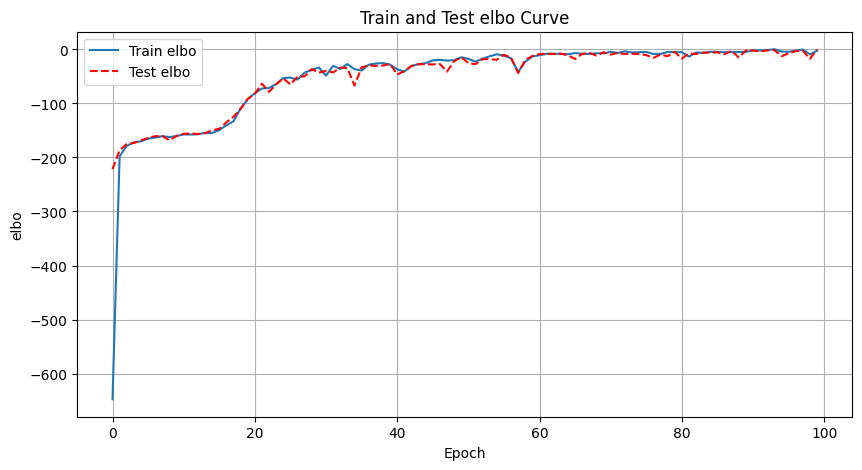

In [22]:
# loader expected shape is (1, seq_len, 2)
# use squeeze(0) to remove the batch_size term so that x becomes (seq_len, 2)
def train(svi, train_loader, use_cuda=False):
    epoch_loss = 0.0
    for angles in train_loader:
        angles = angles.squeeze(0)
        if use_cuda:
            angles = angles.cuda()
        epoch_loss += svi.step(angles)
    # normalized loss by sample number
    normalizer_train = len(train_loader.dataset)
    return epoch_loss / normalizer_train

def evaluate(svi, test_loader, use_cuda=False):
    total_loss = 0.0
    for angles in test_loader:
        angles = angles.squeeze(0)
        if use_cuda:
            angles = angles.cuda()
        total_loss += svi.evaluate_loss(angles)
    normalizer_test = len(test_loader.dataset)
    return total_loss / normalizer_test

# main training process
LEARNING_RATE = 1e-3
USE_CUDA = False
NUM_EPOCHS = 100
TEST_FREQUENCY = 1

pdb_file = "1fsd.pdb"
train_loader, test_loader = setup_data_loaders(pdb_file=pdb_file, train_ratio=0.8)

# clear the Pyro parameter
pyro.clear_param_store()

# VAE model
vae = VAE(input_size=2, z_dim=16, hidden_size=128, output_size=5)
optimizer = Adam({"lr": LEARNING_RATE})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# storage training and test losses
train_elbo = []
test_elbo = []
epochs = []
kappa_values = []
for epoch in range(NUM_EPOCHS):
    train_loss = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-train_loss)

    if epoch % TEST_FREQUENCY == 0:
        test_loss = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-test_loss)

# plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_EPOCHS), train_elbo, label="Train elbo", linestyle="-")
plt.plot(range(0, NUM_EPOCHS, TEST_FREQUENCY), test_elbo, label="Test elbo", linestyle="--", color="red")
plt.xlabel("Epoch")
plt.ylabel("elbo")
plt.title("Train and Test elbo Curve")
plt.legend()
plt.grid(True)
plt.show()

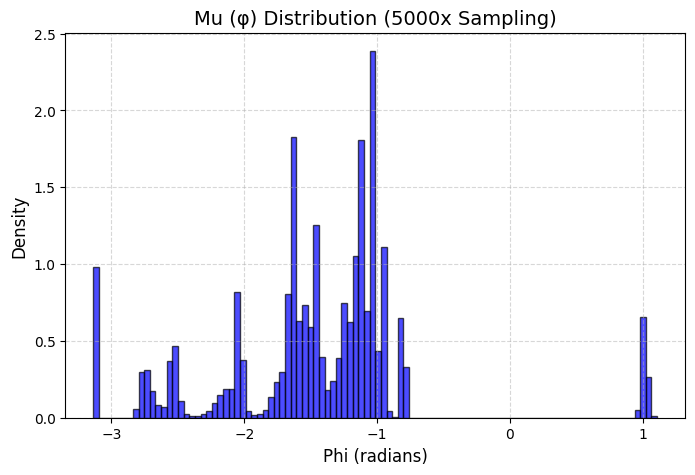

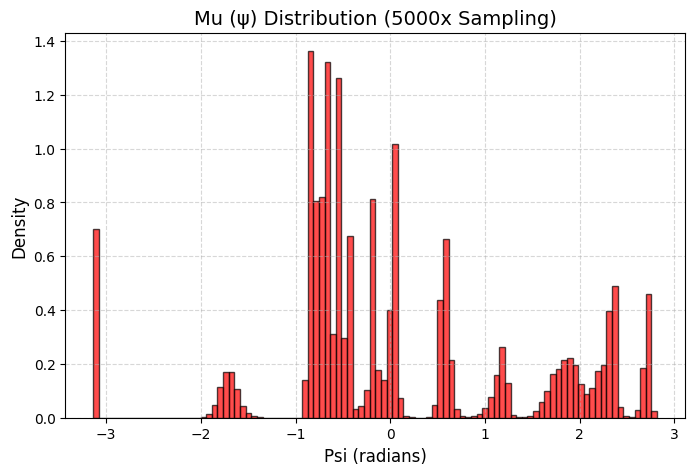

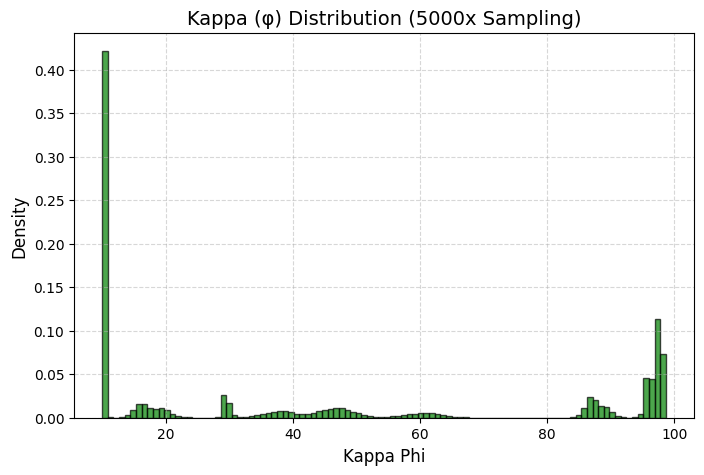

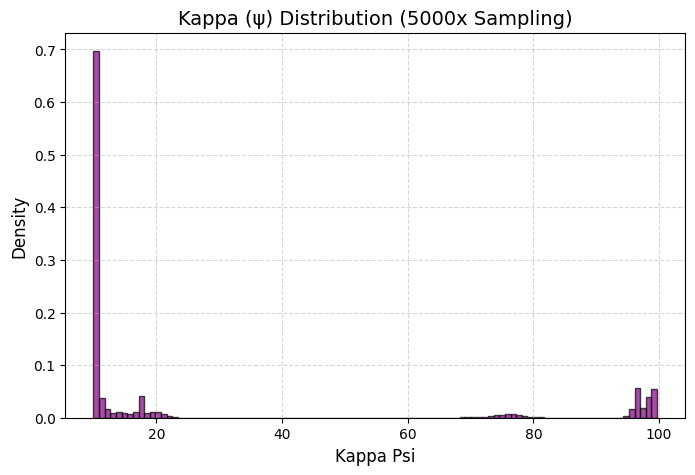

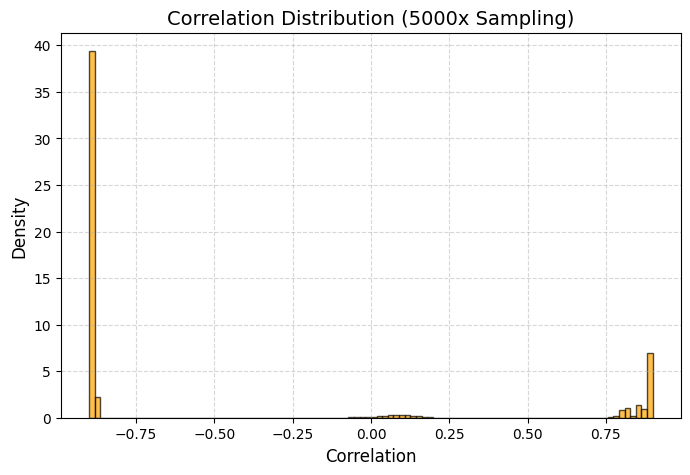

In [23]:
vae.eval()
num_samples = 5000

# choose a sequence from test dataset
with torch.no_grad():
    for batch in test_loader:
        batch = batch.squeeze(0)  # shape: (seq_len, 2)
        seq_len = batch.shape[0]
        z_loc, z_scale = vae.encoder(batch)
        break

# sample 5000 times
phi_list, psi_list = [], []
kappa_phi_list, kappa_psi_list, corr_list = [], [], []

with torch.no_grad():
    for _ in range(num_samples):
        z = Normal(z_loc, z_scale).sample()  # shape: (seq_len, latent_dim)
        pred_params = vae.decoder(z, seq_len)  # shape: (seq_len, 5)
        phi_list.append(pred_params[:, 0].cpu().numpy())
        psi_list.append(pred_params[:, 1].cpu().numpy())
        kappa_phi_list.append(pred_params[:, 2].cpu().numpy())
        kappa_psi_list.append(pred_params[:, 3].cpu().numpy())
        corr_list.append(pred_params[:, 4].cpu().numpy())

# Splice into a one-dimensional array: shape = (5000 * seq_len,)
phi_all = np.concatenate(phi_list)
psi_all = np.concatenate(psi_list)
kappa_phi_all = np.concatenate(kappa_phi_list)
kappa_psi_all = np.concatenate(kappa_psi_list)
corr_all = np.concatenate(corr_list)

def plot_histogram(data, title, xlabel, color='blue'):
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=100, density=True, color=color, alpha=0.7, edgecolor='black')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_histogram(phi_all, "Mu (φ) Distribution (5000x Sampling)", "Phi (radians)", color='blue')
plot_histogram(psi_all, "Mu (ψ) Distribution (5000x Sampling)", "Psi (radians)", color='red')
plot_histogram(kappa_phi_all, "Kappa (φ) Distribution (5000x Sampling)", "Kappa Phi", color='green')
plot_histogram(kappa_psi_all, "Kappa (ψ) Distribution (5000x Sampling)", "Kappa Psi", color='purple')
plot_histogram(corr_all, "Correlation Distribution (5000x Sampling)", "Correlation", color='orange')


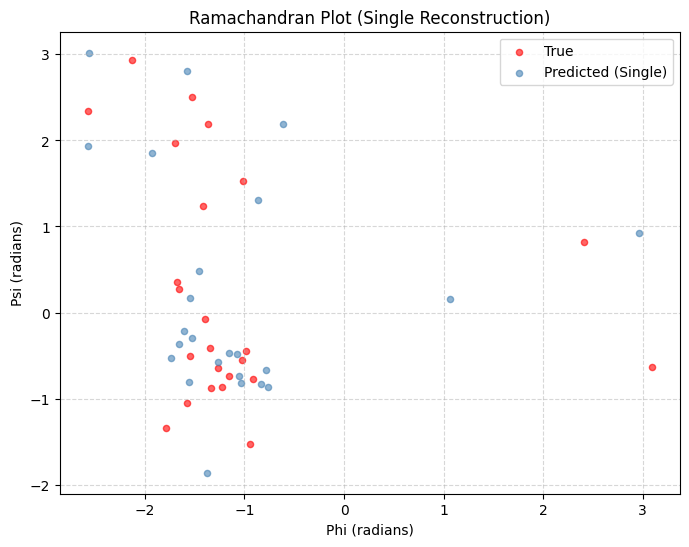

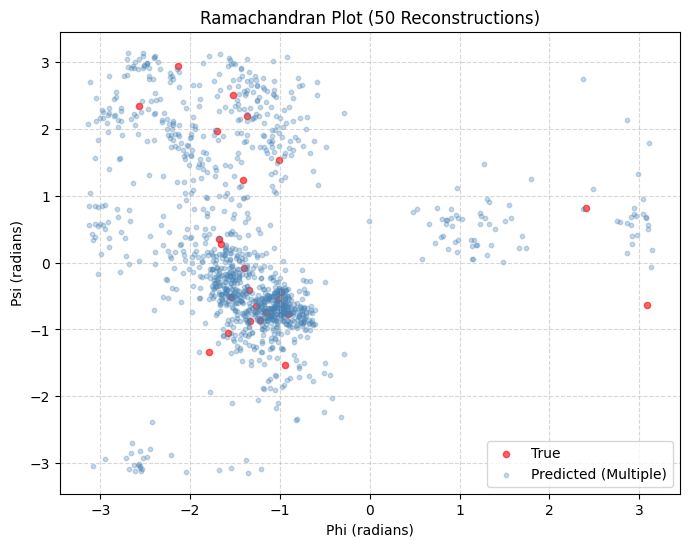

In [24]:
vae.eval()
num_samples = 50  # Number of reconstructions

# Select one sequence from the test set
sample_data = next(iter(test_loader)).squeeze(0)  # Select one test sequence
seq_len = sample_data.shape[0]  # Get sequence length

true_phi = sample_data[:, 0].cpu().numpy()
true_psi = sample_data[:, 1].cpu().numpy()

# Store reconstructed angles
reconstructed_phi_single = []
reconstructed_psi_single = []
reconstructed_phi_multiple = []
reconstructed_psi_multiple = []

with torch.no_grad():
    # Perform encoding and reconstruction
    pred_params_single = vae.reconstruct(sample_data)  # Use the modified reconstruct method
    reconstructed_phi_single = pred_params_single[:, 0].cpu().numpy()
    reconstructed_psi_single = pred_params_single[:, 1].cpu().numpy()

    # Multiple Reconstructions (50 times)
    for _ in range(num_samples):
        pred_params_multi = vae.reconstruct(sample_data)  # Multiple reconstructions
        reconstructed_phi_multiple.append(pred_params_multi[:, 0].cpu().numpy())
        reconstructed_psi_multiple.append(pred_params_multi[:, 1].cpu().numpy())

# Convert lists to numpy arrays
reconstructed_phi_multiple = np.array(reconstructed_phi_multiple).flatten()
reconstructed_psi_multiple = np.array(reconstructed_psi_multiple).flatten()

# Single Reconstruction Ramachandran Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_phi, true_psi, s=20, c='red', alpha=0.6, label='True')
plt.scatter(reconstructed_phi_single, reconstructed_psi_single, s=20, c='steelblue', alpha=0.6, label='Predicted (Single)')
plt.xlabel('Phi (radians)')
plt.ylabel('Psi (radians)')
plt.title('Ramachandran Plot (Single Reconstruction)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Multiple Reconstructions Ramachandran Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_phi, true_psi, s=20, c='red', alpha=0.6, label='True')
plt.scatter(reconstructed_phi_multiple, reconstructed_psi_multiple, s=10, c='steelblue', alpha=0.3, label='Predicted (Multiple)')
plt.xlabel('Phi (radians)')
plt.ylabel('Psi (radians)')
plt.title('Ramachandran Plot (50 Reconstructions)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [25]:
# compute RMSD for a single reconstruction
def compute_rmsd(true_phi, true_psi, pred_phi, pred_psi):
    """
    Compute RMSD given true and predicted phi/psi angles for a single reconstruction.

    Args:
        true_phi: True phi angles (1D array)
        true_psi: True psi angles (1D array)
        pred_phi: Predicted phi angles (1D array)
        pred_psi: Predicted psi angles (1D array)

    Returns:
        RMSD value (float)
    """
    rmsd = np.sqrt(np.mean((pred_phi - true_phi) ** 2 + (pred_psi - true_psi) ** 2))
    return rmsd

# compute RMSD for a single reconstruction
rmsd_single = compute_rmsd(true_phi, true_psi, reconstructed_phi_single, reconstructed_psi_single)

# print RMSD value
print(f"Total RMSD (Single Reconstruction): {rmsd_single:.4f}")


Total RMSD (Single Reconstruction): 0.6226


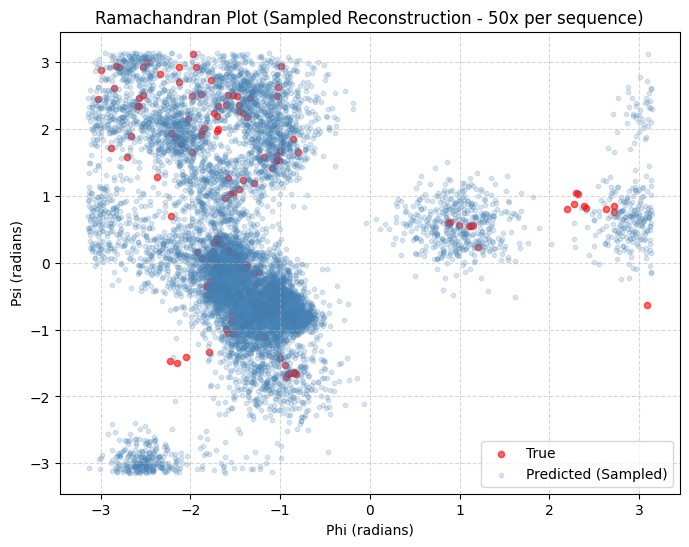

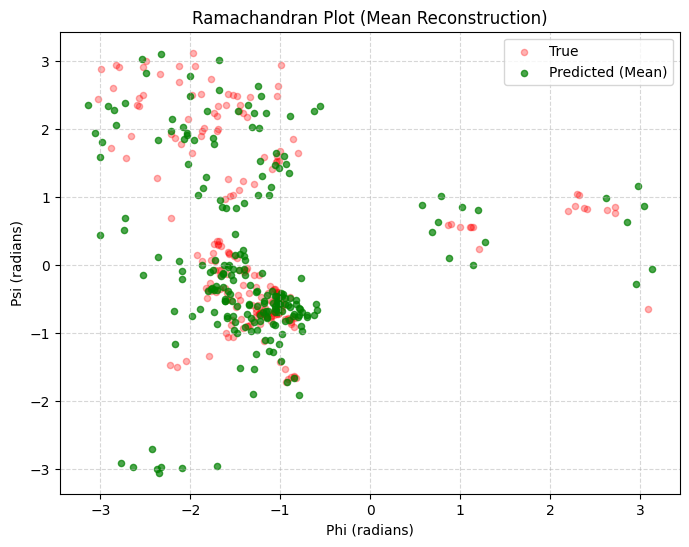

In [26]:
vae.eval()
num_samples = 50

# store all data
all_true_phi, all_true_psi = [], []
all_reconstructed_phi_sampled, all_reconstructed_psi_sampled = [], []
all_reconstructed_phi_mean, all_reconstructed_psi_mean = [], []

with torch.no_grad():
    for sample_data in test_loader:
        sample_data = sample_data.squeeze(0)  # Remove batch dimension (seq_len, 2)

        # preserve true angles
        true_phi = sample_data[:, 0].cpu().numpy()
        true_psi = sample_data[:, 1].cpu().numpy()
        all_true_phi.extend(true_phi)
        all_true_psi.extend(true_psi)

        # sampled Reconstruction (50 reconstructions per sequence sample)
        for _ in range(num_samples):
            sampled_angles = vae.reconstruct(sample_data)
            all_reconstructed_phi_sampled.extend(sampled_angles[:, 0].cpu().numpy())
            all_reconstructed_psi_sampled.extend(sampled_angles[:, 1].cpu().numpy())

        # mean Reconstruction
        mean_angles = vae.reconstruct_from_mean(sample_data)
        all_reconstructed_phi_mean.extend(mean_angles[:, 0].cpu().numpy())
        all_reconstructed_psi_mean.extend(mean_angles[:, 1].cpu().numpy())

# transfer into numpy array
all_true_phi = np.array(all_true_phi)
all_true_psi = np.array(all_true_psi)
all_reconstructed_phi_sampled = np.array(all_reconstructed_phi_sampled)
all_reconstructed_psi_sampled = np.array(all_reconstructed_psi_sampled)
all_reconstructed_phi_mean = np.array(all_reconstructed_phi_mean)
all_reconstructed_psi_mean = np.array(all_reconstructed_psi_mean)

# sampled Reconstruction Plot
plt.figure(figsize=(8, 6))
plt.scatter(all_true_phi, all_true_psi, s=20, c='red', alpha=0.6, label='True')
plt.scatter(all_reconstructed_phi_sampled, all_reconstructed_psi_sampled,
            s=10, c='steelblue', alpha=0.2, label='Predicted (Sampled)')
plt.xlabel('Phi (radians)')
plt.ylabel('Psi (radians)')
plt.title('Ramachandran Plot (Sampled Reconstruction - 50x per sequence)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# mean Reconstruction Plot
plt.figure(figsize=(8, 6))
plt.scatter(all_true_phi, all_true_psi, s=20, c='red', alpha=0.3, label='True')
plt.scatter(all_reconstructed_phi_mean, all_reconstructed_psi_mean,
            s=20, c='green', alpha=0.7, label='Predicted (Mean)')
plt.xlabel('Phi (radians)')
plt.ylabel('Psi (radians)')
plt.title('Ramachandran Plot (Mean Reconstruction)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [27]:
# compute RMSD
def compute_rmsd(true_phi, true_psi, pred_phi, pred_psi):
    """
    Compute the RMSD between true and predicted dihedral angles.
    """
    rmsd = np.sqrt(np.mean((pred_phi - true_phi) ** 2 + (pred_psi - true_psi) ** 2))
    return rmsd

# compute RMSD for Mean Reconstruction
rmsd_mean = compute_rmsd(
    np.array(all_true_phi),
    np.array(all_true_psi),
    np.array(all_reconstructed_phi_mean),
    np.array(all_reconstructed_psi_mean)
)

# print RMSD result
print(f"Total RMSD (Mean Reconstruction): {rmsd_mean:.4f}")


Total RMSD (Mean Reconstruction): 1.3950
